# Estelle's workflow notebook

1. Create datasets (from created functions)
2. Model
    - Test to visualize CNN layers
3. Prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pokedex.utils_dataset import create_dataset, reduce_dataset
from pokedex.augmentation import get_augment_data
from pokedex.modeling import preprocessing
from pokedex.prediction import card_prediction_processing
from pokedex.edges.deformer import deform_card

2024-06-10 14:24:11.845584: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Create datasets
Using the created functions

In [4]:
# Create the dataset from SETINFO list in __init.py__ file
df = create_dataset()

On-going set: dv1
On-going set: swsh9
On-going set: swsh45
On-going set: swsh6
On-going set: swsh12pt5
On-going set: xy1
On-going set: xy2
Failed to retrieve image. HTTP Status code: 404
On-going set: xy3
Failed to retrieve image. HTTP Status code: 404
On-going set: g1
Failed to retrieve image. HTTP Status code: 404
Failed to retrieve image. HTTP Status code: 404
Failed to retrieve image. HTTP Status code: 404
Failed to retrieve image. HTTP Status code: 404
Failed to retrieve image. HTTP Status code: 404
Failed to retrieve image. HTTP Status code: 404
Failed to retrieve image. HTTP Status code: 404
Failed to retrieve image. HTTP Status code: 404
Failed to retrieve image. HTTP Status code: 404
Failed to retrieve image. HTTP Status code: 404
Failed to retrieve image. HTTP Status code: 404
Failed to retrieve image. HTTP Status code: 404
Failed to retrieve image. HTTP Status code: 404
Failed to retrieve image. HTTP Status code: 404
Failed to retrieve image. HTTP Status code: 404
Failed to 

In [ ]:
# Save the dataset to json file in the raw_data folder
df.to_json('../../raw_data/dict_dataset_full.json')

In [ ]:
# From the dataset with all the cards
# - cap number of cards per set, 
# - split into left/right datasets,
# - saves both of them
reduce_dataset('../../raw_data/dict_dataset_full.json')

In [ ]:
# Load the left and right datasets and augment the data to get 1000 cards per set
df_right = get_augment_data('../../raw_data/dict_reduceddataset_right.json')
df_left = get_augment_data('../../raw_data/dict_reduceddataset_left.json')

## Model
Make a mock up model to get the flow of training and prediction

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
HARD_CODED_HEIGHT = 72
HARD_CODED_WIDTH = 200

In [5]:
nb_epochs=1
batch_size=32

In [6]:
# Preprocessing and split the data into train, val and test sets
# gives the label encoder to be able to retransform the target values into set id/name
X_train, y_train, X_val, y_val, X_test, y_test, label_encoder = preprocessing('../../raw_data/dict_reduceddataset_right.json')

In [7]:
# Mock model, first try
model = Sequential([
    layers.Conv2D(16, (5,5), padding='same', activation="relu", input_shape=(HARD_CODED_HEIGHT,HARD_CODED_WIDTH,1)),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(32, (3,3), padding='same', activation="relu"),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(11, activation='softmax')
])
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

/Users/estelle/.pyenv/versions/3.10.6/envs/project_pokereader/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
es = EarlyStopping(patience = 2, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs = nb_epochs,
    batch_size = batch_size,
    validation_data = (X_val, y_val),
    callbacks = es,
    verbose = 1
)

241/241 ━━━━━━━━━━━━━━━━━━━━ 60s 245ms/step - accuracy: 0.2511 - loss: 2.1494 - val_accuracy: 0.7577 - val_loss: 0.8107


In [30]:
model.evaluate(X_test,y_test, return_dict=True)

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9969 - loss: 0.0298


{'accuracy': 0.9921212196350098, 'loss': 0.03775608912110329}

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 72, 200, 16)    │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 100, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 36, 100, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,079,011 (42.26 MB)

 Trainable params: 3,693,003 (14.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,386,008 (28.18 MB)

### Test to visualize CNN layers

In [41]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)

print(layer_names)

['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'dropout', 'flatten', 'dense', 'dense_1']


In [63]:
layer_names = ['conv2d_4', 'max_pooling2d_4', 'conv2d_5', 'max_pooling2d_5']

layers_to_visualize = layer_names
number = 0

name = X_test[number]
test_image_array = np.asarray(name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


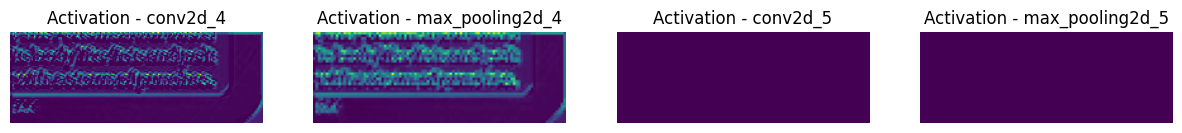

In [74]:
def visualize_activations(model, img_array, layers):

    img_array = np.expand_dims(img_array, axis=0)
    # img_array = preprocess_input(img_array)

    outputs = [model.get_layer(layer).output for layer in layers]
    activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=outputs)

    activations = activation_model.predict(img_array)

    plt.figure(figsize=(15, 8))
    for i, activation in enumerate(activations):
        plt.subplot(1, len(layers), i + 1)
        plt.imshow(activation[0, :, :, 0], cmap='viridis')  # Adjust the indexing if needed
        plt.title(f'Activation - {layers[i]}')
        plt.axis('off')

    plt.show()

visualize_activations(model, test_image_array, layers_to_visualize)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted class: xy1
Confidence: 99.53%
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


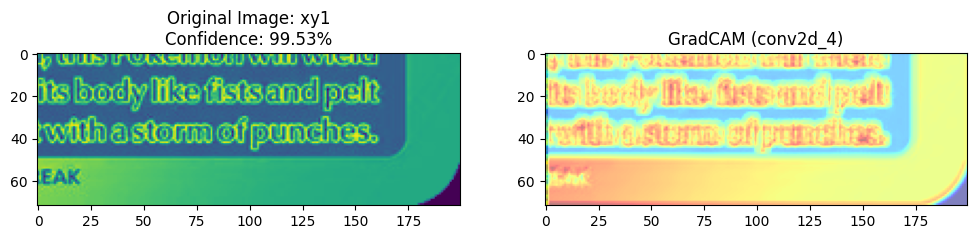

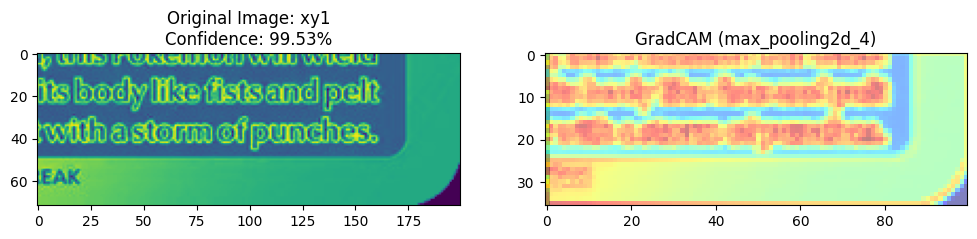

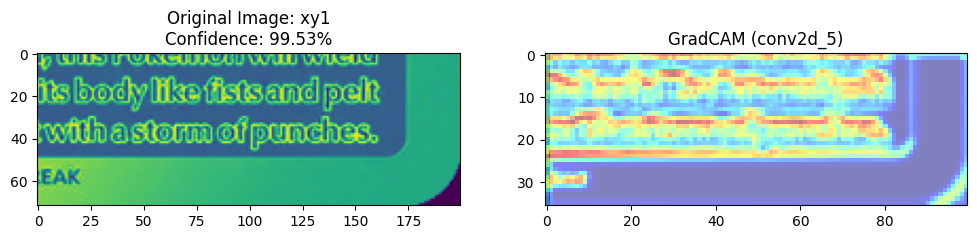

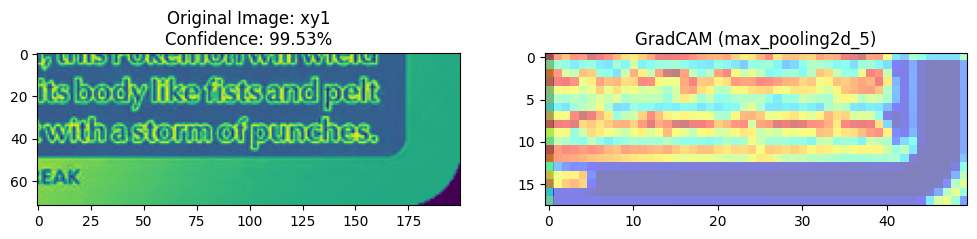

In [98]:
#Version 2 DenseNet 121
def generate_gradcam(model, img_array, layer_name):
    img_array = np.expand_dims(img_array, axis=0)
    grad_model = tf.keras.Model([model.inputs[0]], [model.get_layer(layer_name).output, model.outputs[0]])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, 1]

    grads = tape.gradient(loss, conv_output)

    # Check if gradients are not None before proceeding
    if grads is None:
        print("Gradients are None. Skipping GradCAM computation.")
        return None, None, None

    guided_grads = (tf.cast(conv_output > 0, "float32") * tf.cast(grads > 0, "float32") * grads)

    weights = tf.reduce_mean(guided_grads, axis=(0, 1, 2))
    cam = np.dot(conv_output[0], weights)

    return cam, conv_output, predictions


def plot_gradcam(model, img_array, layer_name, label, confidence):
    cam, _, _ = generate_gradcam(model, img_array, layer_name)

    # Check if cam is None
    if cam is None:
        print("GradCAM is None. Skipping visualization.")
        return

    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array)
    plt.title(f'Original Image: {label}\nConfidence: {confidence:.2%}')

    plt.subplot(1, 2, 2)
    plt.imshow(img_array[0], alpha=0.8)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title(f'GradCAM ({layer_name})')

    plt.show()

predictions = model.predict(graybottomright)

predicted_class_index = np.argmax(predictions[0])
confidence = predictions[0][predicted_class_index]

class_labels = label_encoder.classes_
predicted_label = class_labels[predicted_class_index]

print(f"Predicted class: {predicted_label}")
print(f"Confidence: {confidence:.2%}")

print(y_test[number])

for layer_name in layer_names:
    plot_gradcam(model, test_image_array, layer_name, predicted_label, confidence)

## Prediction

In [31]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [32]:
# Load a card that we took by hand (with a background)
png_filepath = '../../raw_data/PokemonCards/xy1-94.jpg'
png_pil_img = Image.open(png_filepath)

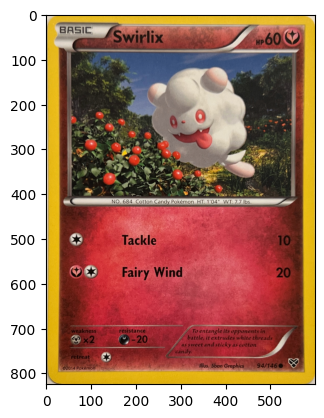

In [33]:
# Use the edge detection functions to crop the card without picture background
card_image = deform_card(png_filepath)
plt.imshow(card_image)

In [35]:
# From the detected card, get the bottom left and right corners
graybottomleft, graybottomright = card_prediction_processing(card_image)

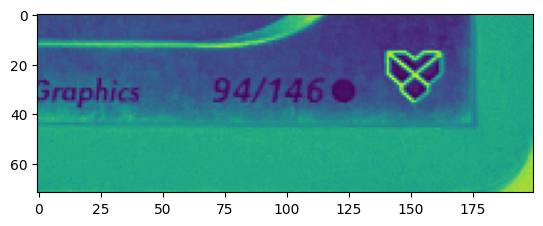

In [75]:
# Bottom right corner has the info
plt.imshow(graybottomright[0,:,:,:])

In [37]:
# Predict the card using the trained model 
predictions = model.predict(graybottomright)
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


array([[2.6631654e-17, 1.4006060e-13, 6.1530747e-10, 5.1523400e-16,
        5.5871640e-15, 9.9994040e-01, 2.5100130e-07, 5.3886946e-05,
        5.4814336e-06, 6.2895558e-17, 3.7446357e-17]], dtype=float32)

In [38]:
label_encoder.classes_

array(['dp1', 'dp2', 'dv1', 'g1', 'no', 'xy1', 'xy2', 'xy3', 'xy4', 'xy6',
       'xy7'], dtype=object)

In [39]:
# Loaded card was xy1
np.argmax(predictions)

5